# Longest Common Subsequence


[Longest Common Subsequence](https://en.wikipedia.org/wiki/Longest_common_subsequence)

## Small example

In [1]:
function init_lengths!(lengths, x, y)
    lengths[1,1] = 0
    for i in eachindex(x)
        lengths[i+1, 1] = 0
    end
    for j in eachindex(y)
        lengths[1, j+1] = 0
    end
    lengths
end

x = collect("GAC")
y = collect("AGCAT")
lengths = -ones(Int, 1+length(x), 1+length(y))
init_lengths!(lengths, x, y)

4×6 Matrix{Int64}:
 0   0   0   0   0   0
 0  -1  -1  -1  -1  -1
 0  -1  -1  -1  -1  -1
 0  -1  -1  -1  -1  -1

In [2]:
using PrettyTables
function display(lengths, x, y)
    table = hcat(['∅', x...], lengths)
    pretty_table(table;
                 header = ["", '∅', y...],
                 formatters = (v, i, j) -> v==-1 ? "" : v)
end
display(lengths, x, y)

┌───┬───┬───┬───┬───┬───┬───┐
│   │ ∅ │ A │ G │ C │ A │ T │
├───┼───┼───┼───┼───┼───┼───┤
│ ∅ │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
│ G │ 0 │   │   │   │   │   │
│ A │ 0 │   │   │   │   │   │
│ C │ 0 │   │   │   │   │   │
└───┴───┴───┴───┴───┴───┴───┘


In [3]:
function fill_lengths!(lengths, x, y, ir=eachindex(x), jr=eachindex(y))
    for j in jr
        for i in ir
            lengths[i+1, j+1] = if x[i] == y[j]
                lengths[i, j] + 1
            else
                max(lengths[i+1, j], lengths[i, j+1])
            end
        end
    end
end

fill_lengths!(lengths, x, y, 1:1)
display(lengths, x, y)

┌───┬───┬───┬───┬───┬───┬───┐
│   │ ∅ │ A │ G │ C │ A │ T │
├───┼───┼───┼───┼───┼───┼───┤
│ ∅ │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
│ G │ 0 │ 0 │ 1 │ 1 │ 1 │ 1 │
│ A │ 0 │   │   │   │   │   │
│ C │ 0 │   │   │   │   │   │
└───┴───┴───┴───┴───┴───┴───┘


In [4]:
fill_lengths!(lengths, x, y, 2:2)
display(lengths, x, y)

┌───┬───┬───┬───┬───┬───┬───┐
│   │ ∅ │ A │ G │ C │ A │ T │
├───┼───┼───┼───┼───┼───┼───┤
│ ∅ │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
│ G │ 0 │ 0 │ 1 │ 1 │ 1 │ 1 │
│ A │ 0 │ 1 │ 1 │ 1 │ 2 │ 2 │
│ C │ 0 │   │   │   │   │   │
└───┴───┴───┴───┴───┴───┴───┘


In [5]:
fill_lengths!(lengths, x, y, 3:3)
display(lengths, x, y)

┌───┬───┬───┬───┬───┬───┬───┐
│   │ ∅ │ A │ G │ C │ A │ T │
├───┼───┼───┼───┼───┼───┼───┤
│ ∅ │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │
│ G │ 0 │ 0 │ 1 │ 1 │ 1 │ 1 │
│ A │ 0 │ 1 │ 1 │ 1 │ 2 │ 2 │
│ C │ 0 │ 1 │ 1 │ 2 │ 2 │ 2 │
└───┴───┴───┴───┴───┴───┴───┘


In [6]:
function backtrack(lengths, x, y)
    i = lastindex(x)
    j = lastindex(y)
    subseq = []
    while lengths[i+1, j+1] != 0
        if x[i] == y[j]
            pushfirst!(subseq, x[i])
            (i, j) = (i-1, j-1)
        elseif lengths[i+1, j] > lengths[i, j+1]
            (i, j) = (i, j-1)
        else
            (i, j) = (i-1, j)
        end
    end
    subseq
end

backtrack(lengths, x, y)

2-element Vector{Any}:
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)

In [7]:
function LCS(x, y)
    lengths = Matrix{Int}(undef, 1+length(x), 1+length(y))
    init_lengths!(lengths, x, y)
    fill_lengths!(lengths, x, y)
    backtrack(lengths, x, y)
end

LCS(x, y)

2-element Vector{Any}:
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)

## Large example

### Plain sequential version

In [8]:
x = rand("ATCG", 4096);
y = rand("ATCG", 8192);
seq = LCS(x, y)

3566-element Vector{Any}:
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 ⋮
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII

### Tiled sequential version

In [9]:
function splitrange(range, nchunks)
    q, r = divrem(length(range), nchunks)
    chunks = UnitRange{Int}[]

    i₁ = first(range)
    for k in 1:nchunks
        n = k <= r ? q+1 : q
        i₂ = i₁ + n
        push!(chunks, i₁:i₂-1)
        i₁ = i₂
    end
    chunks
end

function LCS_tiled(x, y, nx, ny)
    lengths = Matrix{Int}(undef, 1+length(x), 1+length(y))
    init_lengths!(lengths, x, y)

    for irange in splitrange(eachindex(x), nx)
        for jrange in splitrange(eachindex(y), ny)
            fill_lengths!(lengths, x, y, irange, jrange)
        end
    end

    backtrack(lengths, x, y)
end

nx = 8
ny = 12
tiled = LCS_tiled(x, y, nx, ny)
@assert seq == tiled

### Tiled parallel version

In [10]:
using DataFlowTasks

function LCS_par(x, y, nx, ny)
    lengths = Matrix{Int}(undef, 1+length(x), 1+length(y))
    init_lengths!(lengths, x, y)

    for irange in splitrange(eachindex(x), nx)
        for jrange in splitrange(eachindex(y), ny)
            DataFlowTasks.@spawn begin
                @R view(lengths, irange, jrange)
                @W view(lengths, irange .+ 1, jrange .+ 1)
                fill_lengths!(lengths, x, y, irange, jrange)
            end
        end
    end

    barrier = DataFlowTasks.@spawn @R(lengths)
    wait(barrier)

    backtrack(lengths, x, y)
end

par = LCS_par(x, y, nx, ny)
@assert seq == par

### Performance comparison

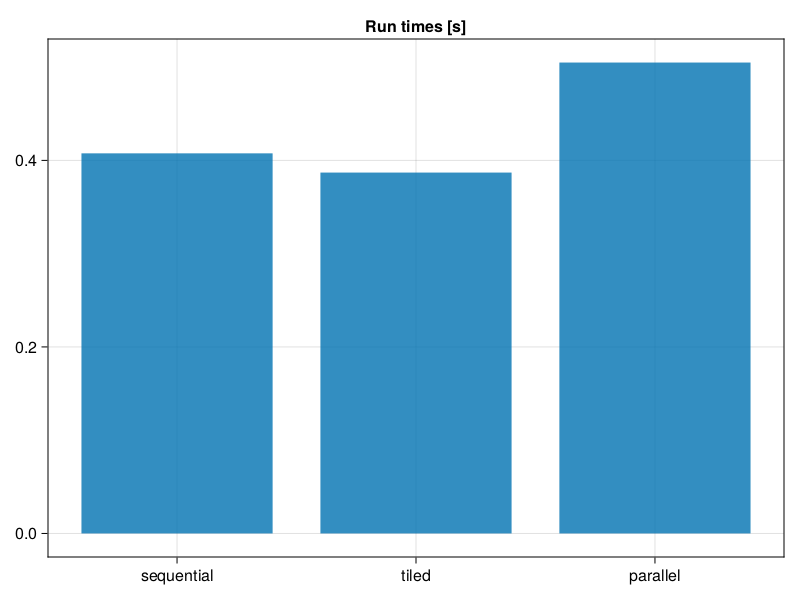

In [11]:
GC.gc(); t_seq   = @elapsed LCS(x, y)
GC.gc(); t_tiled = @elapsed LCS_tiled(x, y, nx, ny)
GC.gc(); t_par   = @elapsed LCS_par(x, y, nx, ny)

using CairoMakie
barplot(1:3, [t_seq, t_tiled, t_par],
        axis = (; title = "Run times [s]",
                xticks = (1:3, ["sequential", "tiled", "parallel"])))

### Profiling of the parallel version

In [12]:
resize!(DataFlowTasks.get_active_taskgraph(), 200)
log_info = DataFlowTasks.@log LCS_par(x, y, nx, ny)

LogInfo with 97 logged tasks
	 critical time: 0.47 seconds

Status `~/.julia/scratchspaces/d1549cb6-e9f4-42f8-98cc-ffc8d067ff5b/weakdeps-1.9/Project.toml`
  [13f3f980] CairoMakie v0.10.11
  [e9467ef8] GLMakie v0.8.11
  [f526b714] GraphViz v0.2.0
  [ee78f7c6] Makie v0.19.11


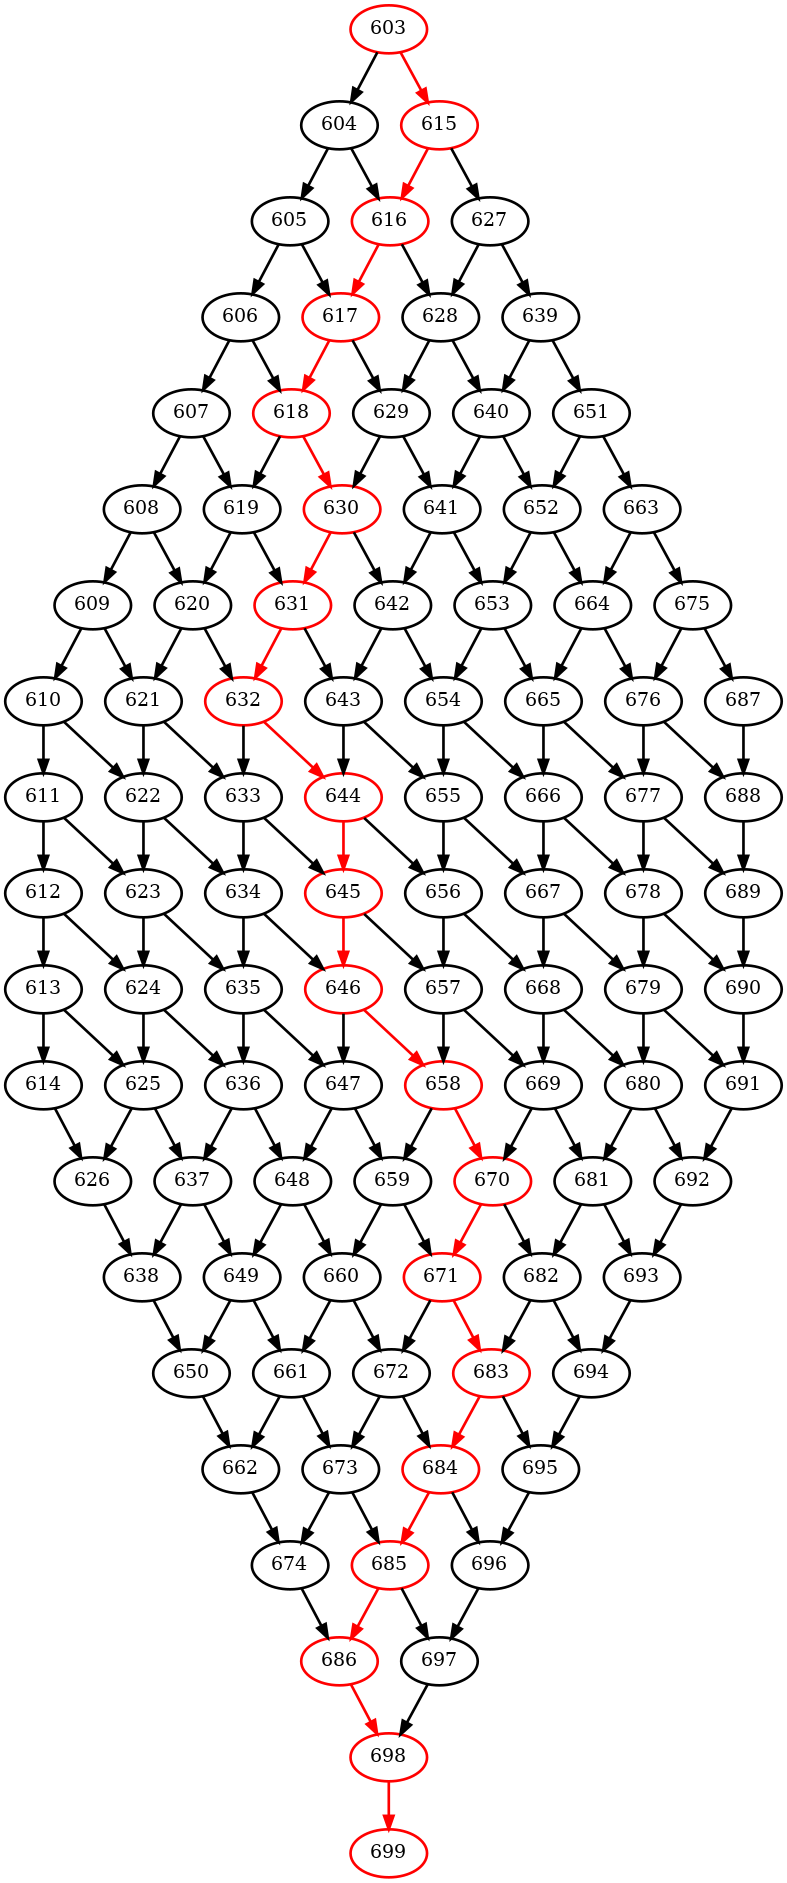

In [13]:
DataFlowTasks.stack_weakdeps_env!()
using GraphViz
GraphViz.Graph(log_info)

[ Info: Computing    : 1.9694272640000008
[ Info: Inserting    : 0.0005794890000000003
[ Info: Other        : 1.8204846389046527


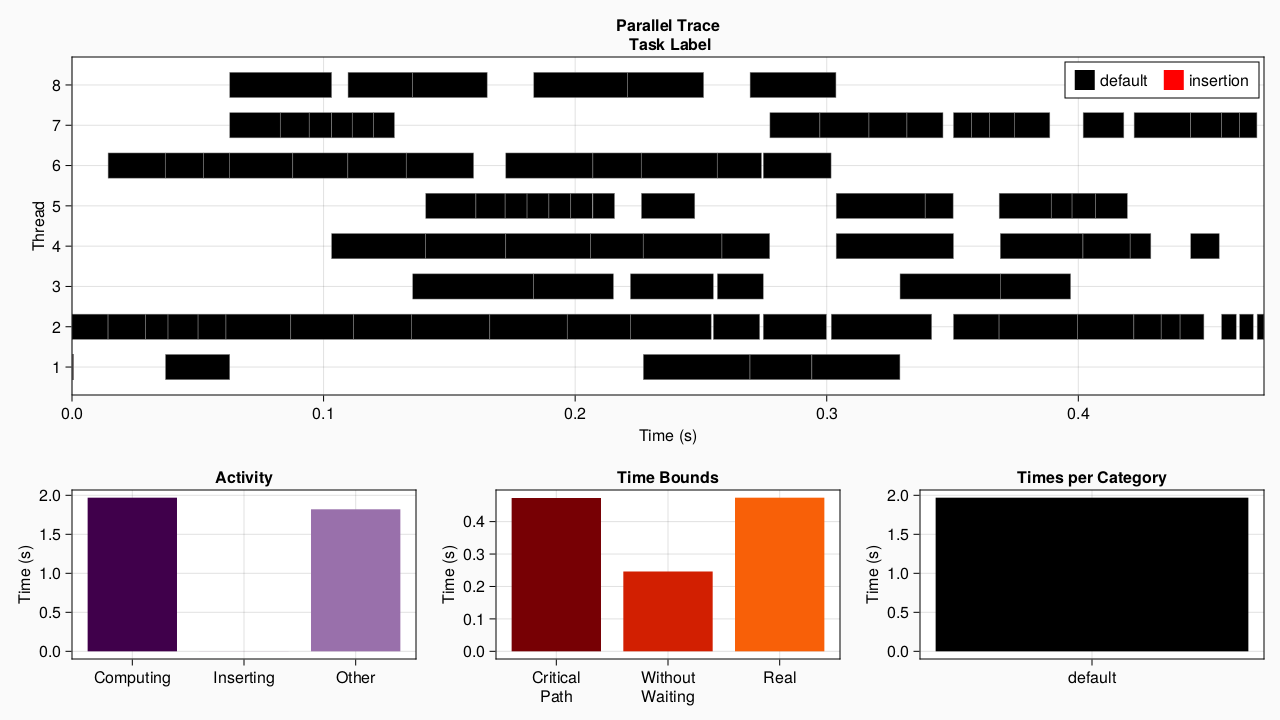

In [14]:
plot(log_info)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*